## FEDOT / AutoML

In [1]:
import pandas
from fedot.api.main import Fedot, TsForecastingParams, Task, TaskTypesEnum, DataTypesEnum, InputData
from fedot.api.main import PrimaryNode, SecondaryNode, Pipeline
import matplotlib.pyplot as plt

In [2]:
df_train = pandas.read_csv('air-passengers-train.csv', index_col=[0])
display(df_train)

df_test = pandas.read_csv('air-passengers-test.csv', index_col=[0])
display(df_test)
print(df_test.shape)

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1958-04,348
1958-05,363
1958-06,435


,#Passengers
Month,
1958-09,404
1958-10,359
1958-11,310
1958-12,337
1959-01,360
1959-02,342
1959-03,406
1959-04,396
1959-05,420


(28, 1)


In [3]:
train_input = InputData(
    task=Task(TaskTypesEnum.ts_forecasting), 
    data_type=DataTypesEnum.ts, 
    idx=range(0, len(df_train)), 
    features=df_train["#Passengers"].to_numpy(), 
    target=df_train["#Passengers"].to_numpy()
)

model = Fedot(
    problem='ts_forecasting', 
    task_params=TsForecastingParams(forecast_length=len(df_test)),
    timeout=10 # min
)

pipeline = model.fit(train_input)

Composition started. Parameters tuning: True. Set of candidate models: ['adareg', 'ar', 'catboostreg', 'dtreg', 'gbr', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'stl_arima', 'svr', 'treg', 'xgbreg', 'scaling', 'normalization', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'sparse_lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 10 min
Pipeline composition started
The pipeline saved in the path: /home/tj_tsai/Fedot/composing_history/0/ef9c0489-a134-4639-9548-1156367e2dec/ef9c0489-a134-4639-9548-1156367e2dec.json.
The pipeline saved in the path: /home/tj_tsai/Fedot/composing_history/0/eaef434b-8259-485f-bf29-ada20ef3eeab/eaef434b-8259-485f-bf29-ada20ef3eeab.json.
The pipeline saved in the path: /home/tj_tsai/Fedot/composing_history/0/0e02117e-f1ca-4c50-9851-eb66cef9d375/0e02117e-f1ca-4c50-9851-eb66cef9d375.json.
...
The pipeline saved in the path: /home/tj_tsai/Fedot/composing_history/11/46c2a4c5-98c

In [4]:
predict_input = InputData(
    task=Task(TaskTypesEnum.ts_forecasting), 
    data_type=DataTypesEnum.ts, 
    idx=range(len(df_train), len(df_train) + len(df_test)), # <--- forecast horizon
    features=df_train["#Passengers"].to_numpy(), # df_train
    target=df_test["#Passengers"].to_numpy()     # df_test
)
y_pred = model.predict(predict_input)
y_pred

array([464.14030761, 402.25569048, 366.3110187 , 394.18456723,
       395.42858609, 371.17178126, 409.81424646, 396.20998508,
       417.27122884, 494.35535024, 554.76456864, 567.83774829,
       520.91808808, 448.18984456, 406.20200491, 436.0122833 ,
       435.5224223 , 408.37017674, 448.77296534, 437.14798979,
       465.08939035, 557.35874152, 624.90689133, 638.98796375,
       583.49127605, 497.53821998, 446.45004747, 475.15824248])

In [5]:
df_pred = pandas.DataFrame(
    y_pred, index=df_test.index, columns=['#Passengers'])

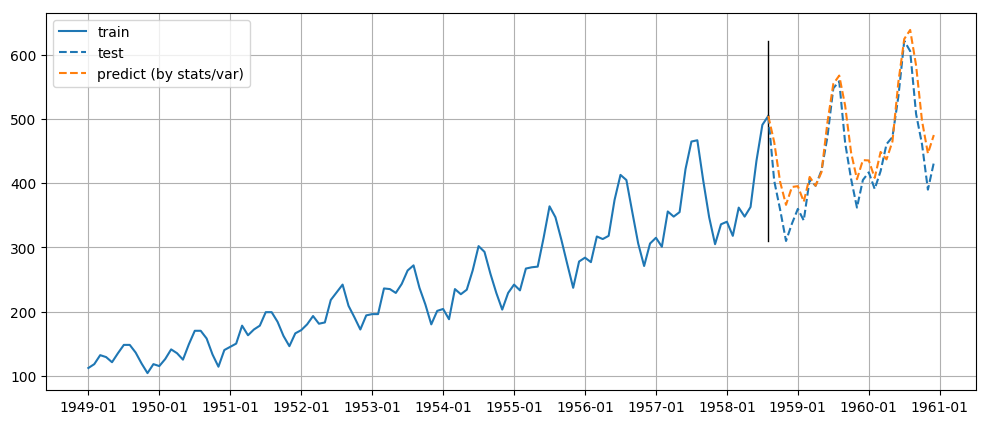

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5), dpi=100)

# training part
plt.plot(df_train[['#Passengers']], color='tab:blue', label='train')

# separating line
plt.plot([df_train.index[-1], df_train.index[-1]],
        [min(df_test[df_train.columns[0]]), max(df_test[df_train.columns[0]])],
        color='black', linewidth=1)

# testing part
x = [df_train.index[-1]]
x.extend(df_test.index)
y = [df_train['#Passengers'].to_numpy()[-1]]
y.extend(df_test['#Passengers'].to_numpy())
plt.plot(x, y, color='tab:blue', linestyle='dashed', label='test')

# predicting part
x = [df_train.index[-1]]
x.extend(df_pred.index)
y = [df_train['#Passengers'].to_numpy()[-1]]
y.extend(df_pred['#Passengers'].to_numpy())
plt.plot(x, y, color='tab:orange', linestyle='dashed', label='predict (by stats/var)')


plt.xticks([str(y) + '-01' for y in range(1949, 1962)])
plt.legend()
plt.grid()
plt.show()

In [7]:
from sklearn.metrics import r2_score, mean_squared_error

print('predict:')
print(' - R2:', round(r2_score(df_test, df_pred), 6))
print(' - MSE:', round(mean_squared_error(df_test, df_pred, squared=True), 6))
print(' - RMSE:', round(mean_squared_error(df_test, df_pred, squared=False), 6))


predict:
 - R2: 0.777209
 - MSE: 1374.11214
 - RMSE: 37.069019


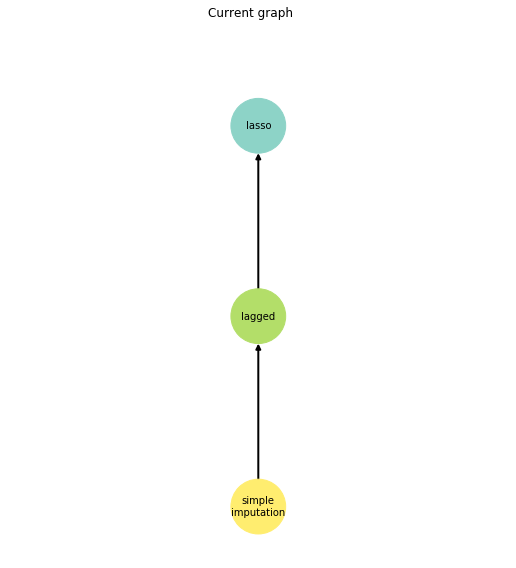

{'depth': 3, 'length': 3, 'nodes': [lasso, lagged, simple_imputation]}

Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [lasso, lagged, simple_imputation]}
lasso - {'alpha': 9.933283162753032}
lagged - {'window_size': 10.038188409382544}
simple_imputation - default_params


In [13]:
# pipeline = model.current_pipeline
pipeline.show()
print(pipeline)
print()
pipeline.print_structure()